# Jet Energy Reolution for separately central jet and forward jet

Notes: 

1. Calculates the distance(in terms of deltaR) between each jet and gen jet in terms of eta and phi
2. Finds the closest gen jet to each jet based on the calculated distance
3. Add an upper cut(deltaR is below 0.4) to avoid issues just to avoid fat tails in the resolution
4. Calculates the ratio of Jet.PT to GenJet.PT for each pair of jet and gen jet for each of the event
5. For RMSE, define some pT binning, group the jets according to that, calculate the RMSE of the ratio separately for each bin using jets belonging to that bin
6. Draw 2D plot between PT_Jet and RMSE(ratio)

#### These numbers which we will get need to be compared to resolution numbers appearing in ATLAS jet/MET paper https://arxiv.org/pdf/2007.02645.pdf
#### and based on that we should decide if we tweak the delphes parameters up or down (and make another sample).
#### See Fig.26a, 29a and 30 and need to just make sure the compatibility with ATLAS is reasonable in regions where we have most of our jets

--> Jet.PT is using instead of Jet.Energy

In [5]:
import ROOT
import numpy as np
import math
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

#ROOT.gSystem.Load("libDelphes")

try:
    ROOT.gInterpreter.Declare('#include "classes/DelphesClasses.h"')
    ROOT.gInterpreter.Declare('#include "external/ExRootAnalysis/ExRootTreeReader.h"')
except:
    pass

def energy_resolution(root_file_path):
    # Create chain of root trees
    chain = ROOT.TChain("Delphes")
    chain.Add(root_file_path)

    # Create object of class ExRootTreeReader
    treeReader = ROOT.ExRootTreeReader(chain)
    numberOfEntries = treeReader.GetEntries()

    # Get pointers to the branches containing Jet and GenJet information
    branchJet = treeReader.UseBranch("Jet")
    branchGenJet = treeReader.UseBranch("GenJet")

    # Lists to store Jet PT and corresponding ratios for central jets and forward jets
    central_jet_pts = []
    central_ratios = []

    pt_bins = np.logspace(math.log(15)/math.log(10), math.log(1501)/math.log(10), 30)  # 50 bins from 0 to 1301 GeV

    # Lists to store RMSE for each pT bin
    central_ratios_rmse_bins = []

    # Loop over all events
    for entry in range(numberOfEntries):
        # Load selected branches with data from specified event
        treeReader.ReadEntry(entry)
        
        num_jets = branchJet.GetEntries()
        num_gen_jets = branchGenJet.GetEntries()
        
        # Loop over each jet and its corresponding gen jet
        for i in range(num_jets):
            jet = branchJet.At(i)
            
            # Find the closest gen jet to the jet in terms of deltaR
            closest_gen_jet = None
            min_delta_r = 999999.0
            
            for j in range(num_gen_jets):
                gen_jet = branchGenJet.At(j)
                
                delta_eta = jet.Eta - gen_jet.Eta
                delta_phi = ROOT.TVector2.Phi_mpi_pi(jet.Phi - gen_jet.Phi)
                delta_r = np.sqrt(delta_eta**2 + delta_phi**2)
                if delta_r < 0.4:
                    if delta_r < min_delta_r:
                        min_delta_r = delta_r
                        closest_gen_jet = gen_jet
                    
            # Calculate the ratio of Jet.PT to GenJet.PT
            if closest_gen_jet and 0.2 <= abs(jet.Eta) < 0.7:  # Selecting jets in the specified eta range
                jet_pt_ratio = jet.PT / closest_gen_jet.PT
                central_jet_pts.append(jet.PT)
                central_ratios.append(jet_pt_ratio)

    # Convert lists to numpy arrays for plotting
    central_jet_pts = np.array(central_jet_pts)
    central_ratios = np.array(central_ratios)

    # Loop over each pT bin for RMSE calculation separately for each bin using jets belonging to that bin
    for i in range(len(pt_bins) - 1):
        # Select jets within the current pT bin
        central_jet_pts_bin = central_jet_pts[(central_jet_pts >= pt_bins[i]) & (central_jet_pts < pt_bins[i + 1])]
        central_ratios_bin = central_ratios[(central_jet_pts >= pt_bins[i]) & (central_jet_pts < pt_bins[i + 1])]
        
        # Calculate RMSE for central jets
        if len(central_ratios_bin) > 0:
            central_ratios_rmse_bin = np.nanstd(central_ratios_bin) # Use np.nanstd to ignore NaN values
            central_ratios_rmse_bins.append(central_ratios_rmse_bin)
        else: # Handle the case where there are no elements in the slice
            central_ratios_rmse_bins.append(np.nan)  # or any other value to signify no data

    # Remove NaN values from the data
    valid_indices = ~np.isnan(central_ratios_rmse_bins)
    pt_bins_valid = pt_bins[:-1][valid_indices]
    central_ratios_rmse_bins_valid = np.array(central_ratios_rmse_bins)[valid_indices]

    # Define the fitting function
    def fitting_function(pt, N, S, C):
        return N / pt + S / np.sqrt(pt) + C

    # Fit the function to the data
    popt, pcov = curve_fit(fitting_function, pt_bins_valid, central_ratios_rmse_bins_valid)

    # Plotting
    plt.figure(figsize=(10, 5))
    plt.scatter(pt_bins[:-1], central_ratios_rmse_bins, s=100, c='blue', alpha=0.7, label='Data')
    plt.plot(pt_bins_valid, fitting_function(pt_bins_valid, *popt), color='red', linestyle='-', label='Fit')
    plt.xlabel('Jet PT')
    plt.ylabel('RMSE of Jet PT / GenJet PT')
    plt.title('Jet PT vs RMSE of Jet PT / GenJet PT ')
    plt.grid(True)
    plt.xscale('log')
    plt.legend()
    plt.show()

    # Print the estimated values of N, S, and C
    print("Estimated Parameters:")
    print("N:", popt[0])
    print("S:", popt[1])
    print("C:", popt[2])



# merge all 100k events

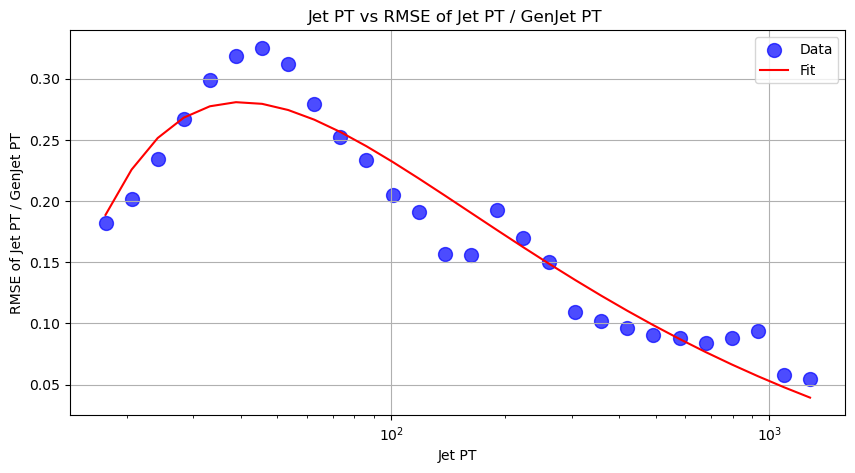

Estimated Parameters:
N: -14.264478244857196
S: 4.510013439126602
C: -0.07557838199795418


In [6]:
energy_resolution("/data/analysis/rhammad/merged_all_100k_pileUp.root")

# try to plot with error bars but those are very small

In [30]:
import ROOT
import numpy as np
import math
import matplotlib.pyplot as plt

ROOT.gSystem.Load("libDelphes")

try:
    ROOT.gInterpreter.Declare('#include "classes/DelphesClasses.h"')
    ROOT.gInterpreter.Declare('#include "external/ExRootAnalysis/ExRootTreeReader.h"')
except:
    pass

def energy_resolution_bars(root_file_path):
    # Create chain of root trees
    chain = ROOT.TChain("Delphes")
    chain.Add(root_file_path)

    # Create object of class ExRootTreeReader
    treeReader = ROOT.ExRootTreeReader(chain)
    numberOfEntries = treeReader.GetEntries()

    # Get pointers to the branches containing Jet and GenJet information
    branchJet = treeReader.UseBranch("Jet")
    branchGenJet = treeReader.UseBranch("GenJet")

    # Lists to store Jet PT and corresponding ratios for central jets and forward jets
    central_jet_pts = []
    central_ratios = []

    pt_bins = np.logspace(math.log(15)/math.log(10), math.log(1501)/math.log(10), 30)  # 50 bins from 0 to 1301 GeV

    # Lists to store RMSE and standard error (SE) for each pT bin
    central_ratios_rmse_bins = []
    central_ratios_se_bins = []

    # Loop over all events
    for entry in range(numberOfEntries):
        # Load selected branches with data from specified event
        treeReader.ReadEntry(entry)
        
        num_jets = branchJet.GetEntries()
        num_gen_jets = branchGenJet.GetEntries()
        
        # Loop over each jet and its corresponding gen jet
        for i in range(num_jets):
            jet = branchJet.At(i)
            
            # Find the closest gen jet to the jet in terms of deltaR
            closest_gen_jet = None
            min_delta_r = 999999.0
            
            for j in range(num_gen_jets):
                gen_jet = branchGenJet.At(j)
                
                delta_eta = jet.Eta - gen_jet.Eta
                delta_phi = ROOT.TVector2.Phi_mpi_pi(jet.Phi - gen_jet.Phi)
                delta_r = np.sqrt(delta_eta**2 + delta_phi**2)
                if delta_r < 0.4:
                    if delta_r < min_delta_r:
                        min_delta_r = delta_r
                        closest_gen_jet = gen_jet
                    
            # Calculate the ratio of Jet.PT to GenJet.PT
            if closest_gen_jet and 0.2 <= abs(jet.Eta) < 0.7:  # Selecting jets in the specified eta range
                jet_pt_ratio = jet.PT / closest_gen_jet.PT
                central_jet_pts.append(jet.PT)
                central_ratios.append(jet_pt_ratio)

    # Convert lists to numpy arrays for plotting
    central_jet_pts = np.array(central_jet_pts)
    central_ratios = np.array(central_ratios)

    # Loop over each pT bin for RMSE and SE calculation separately for each bin using jets belonging to that bin
    for i in range(len(pt_bins) - 1):
        # Select jets within the current pT bin
        central_jet_pts_bin = central_jet_pts[(central_jet_pts >= pt_bins[i]) & (central_jet_pts < pt_bins[i + 1])]
        central_ratios_bin = central_ratios[(central_jet_pts >= pt_bins[i]) & (central_jet_pts < pt_bins[i + 1])]
        
        # Calculate RMSE and SE for central jets
        if len(central_ratios_bin) > 0:
            central_ratios_rmse_bin = np.nanstd(central_ratios_bin)  # Use np.nanstd to ignore NaN values
            central_ratios_se_bin = central_ratios_rmse_bin / np.sqrt(2 * len(central_ratios_bin) - 2)
            #central_ratios_se_bin = max(0.001, central_ratios_se_bin)
            central_ratios_rmse_bins.append(central_ratios_rmse_bin)
            central_ratios_se_bins.append(central_ratios_se_bin)
        else: # Handle the case where there are no elements in the slice
            central_ratios_rmse_bins.append(np.nan)  # or any other value to signify no data
            central_ratios_se_bins.append(np.nan)  # or any other value to signify no data

    print("PT Bins:", pt_bins[:-1])
    print("Number of bins:", len(central_ratios_rmse_bins))
    print("RMSE values:", central_ratios_rmse_bins)
    print("SE values:", central_ratios_se_bins)


    # RMSE of Jet PT to GenJet PT ratios with error bars
    plt.figure(figsize=(10, 5))

    plt.errorbar(pt_bins[:-1], central_ratios_rmse_bins, yerr=central_ratios_se_bins, fmt='o', markersize=5, capsize=3, c='blue', alpha=0.7)
    plt.xlabel('Jet PT')
    plt.ylabel('RMSE of Jet PT / GenJet PT')
    plt.title('Jet PT vs RMSE of Jet PT / GenJet PT ')
    plt.grid(True)
    plt.xscale('log')
    plt.xlim(pt_bins[0], pt_bins[-1])  # Set x-axis limits to the minimum and maximum values in pt_bins
    plt.ylim(0, np.nanmax(central_ratios_rmse_bins) * 1.1)  # Set y-axis limits to 10% above the maximum value of central_ratios_rmse_bins

    plt.show()


PT Bins: [  15.           17.58193851   20.60830411   24.1555957    28.31347988
   33.18705748   38.89952025   45.59526487   53.44354287   62.64273896
   73.42538561   86.06404098  100.8781784   118.24226195  138.5952119
  162.45149952  190.41415166  223.18999368  261.60751627  306.63781759
  359.41915017  421.28569308  493.80127661  578.79891198  678.42712519
  795.20426641  932.08216745 1092.52075672 1280.57551743]
Number of bins: 29
RMSE values: [nan, 0.18233828256170434, 0.20138560472984765, 0.23431464895822326, 0.2670635611456988, 0.298758101718914, 0.3183390518099389, 0.3254335889231678, 0.31192742374830174, 0.27895176697896323, 0.252681796867723, 0.23333289526684362, 0.20483848783076736, 0.19121872721632036, 0.1564430119969743, 0.15615055792956978, 0.19249378789168817, 0.16943165071340566, 0.15013753770691382, 0.10921757829253712, 0.10160279375508673, 0.09629592374851953, 0.09018695173444591, 0.08764935178025805, 0.08360558620228331, 0.08769211710259622, 0.09397779468237283, 0.0

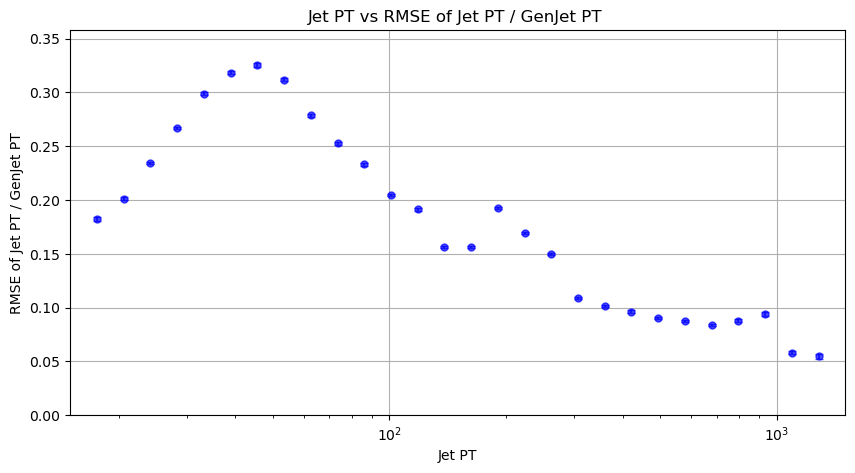

In [31]:
energy_resolution_bars("/data/analysis/rhammad/merged_all_100k_pileUp.root")